# Image Segmentation

Image segmentation, using a modified [U-Net].

## What is Image segmentation?

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of the object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image -- this task is known as **segmentation**. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satallite imaging, just to name a few.

We use the [Oxford-IIIT Pet Dataset] ([Parkhi et al, 2012]). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories.

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

[U-Net]: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
[Oxford-IIIT Pet Dataset]: https://www.robots.ox.ac.uk/%7Evgg/data/pets/
[Parkhi et al, 2012]: https://www.robots.ox.ac.uk/%7Evgg/publications/2012/parkhi12a/parkhi12a.pdf

In [1]:
# Copyright 2022 Victor I. Afolabi
# 
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# !pip install tensorflow-datasets

In [3]:
import os

import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_datasets as tfds

/Users/victor/dev/tutorials/tf-playground/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print(f'Using TensorFlow version: {tf.__version__}')

Using TensorFlow version: 2.9.2


## The Oxford-IIIT Pets dataset

The dataset is [available from TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). The segmentation masks are included in version 3+.

### Data directories

In [5]:
# Base directories.
BASE_DIR = '../../../'

# Model summary plot.
VIZ_DIR = os.path.join(BASE_DIR, 'res/unet')
os.makedirs(VIZ_DIR, exist_ok=True)

# Model directories.
SAVED_MODELS = os.path.join(BASE_DIR, 'saved_models')
UNET_DIR = os.path.join(SAVED_MODELS, 'unet')
UNET_WEIGHTED_DIR = os.path.join(SAVED_MODELS, 'unet-weighted')

# Data directory.
DATA_DIR = os.path.join(BASE_DIR, 'data')
os.makedirs(DATA_DIR, exist_ok=True)

# Model checkpoint during training.
MODEL_CKPT = os.path.join(UNET_DIR,
                          'train/unet-{epoch:03d}.ckpt')
WEIGHTED_MODEL_CKPT = os.path.join(UNET_WEIGHTED_DIR,
                                   'train/unet-{epoch:03d}.ckpt')
os.makedirs(os.path.dirname(MODEL_CKPT),
            exist_ok=True)
os.makedirs(os.path.dirname(WEIGHTED_MODEL_CKPT),
            exist_ok=True)

# Tensorboard log directory.
MODEL_LOG_DIR = os.path.join(UNET_DIR, 'logs')
WEIGHTED_MODEL_LOG_DIR = os.path.join(UNET_WEIGHTED_DIR, 'logs')
os.makedirs(MODEL_LOG_DIR, exist_ok=True)
os.makedirs(WEIGHTED_MODEL_LOG_DIR, exist_ok=True)

# Saved model.
MODEL_PATH = os.path.join(UNET_DIR, 'weights')
WEIGHTED_MODEL_PATH = os.path.join(UNET_WEIGHTED_DIR, 'weights')
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(WEIGHTED_MODEL_PATH, exist_ok=True)

# TFLite model path.
TF_LITE_MODEL = os.path.join(UNET_DIR, 'tflite/unet.tflite')
TF_LITE_WEIGHTED_MODEL = os.path.join(UNET_WEIGHTED_DIR,
                                      'tflite/unet-weighted.tflite')
os.makedirs(os.path.dirname(TF_LITE_MODEL), exist_ok=True)
os.makedirs(os.path.dirname(TF_LITE_WEIGHTED_MODEL), exist_ok=True)

### Load *(and maybe download)* the data

In [6]:
# Download (if not already) & load the dataset.
dataset, info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    data_dir=DATA_DIR,
    with_info=True
)

Metal device set to: Apple M1


2022-09-19 18:23:39.263058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-19 18:23:39.263189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In addition, the image color values are normalized to the `[0, 1]` range. Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are: {0, 1, 2}.

### Hyperparameters

In [7]:
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL = 128, 128, 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)

OUTPUT_CLASSES, VAL_SUBSPLITS = 3, 5
BATCH_SIZE, BUFFER_SIZE = 64, 1000
EPOCHS, LEARNING_RATE = 10, 1e-3
SAVE_FREQ = 5 * BATCH_SIZE

TRAIN_LENGTH = info.splits['train'].num_examples
VAL_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

### Normalize the data

In [8]:
def normalize(
    input_image: tf.TensorArray,
    input_mask: tf.TensorArray
) -> tuple[tf.TensorArray, tf.TensorArray]:
    """Normalize image & image mask.
    
    Arguments:
        input_image (tf.TensorArray): Input image in range [0, 255].
        input_mask (tf.TensorArray): Input mask in range [1, 3].
    
    Returns:
        tuple[tf.TensorArray, tf.TensorArray]:
            Normalized image in range [0, 1] and normalized image
            mask in range [0, 2].
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    
    return input_image, input_mask


def load_image(datapoint: dict[str, tf.Tensor]) -> tuple[tf.TensorArray, tf.TensorArray]:
    """Resize and normalize image and image mask.
    
    Arguments:
        datapoint (dict[str, Tf.Tensor]): Each image data.
    
    Returns:
        tuple[tf.TensorArray, tf.TensorArray]:
            Resized & normalized image & image mask.
    """
    input_image = tf.image.resize(datapoint['image'], IMG_SIZE)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], IMG_SIZE)
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [9]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='../../../data/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
   

In [10]:
info.splits['train'].num_examples, info.splits['test'].num_examples

(3680, 3669)

In [11]:
dataset

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [12]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
train_images, test_images

(<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>,
 <ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>)

### Augment the data

In [14]:
class Augment(tf.keras.layers.Layer):
    """Randomly flip both image and image mask."""
    def __init__(self, seed: int = 42) -> None:
        """Augment the images and labels by flipping them randomly.
        
        Arguments:
            seed (int, optional): Random seed number. Defaults to 42.
        """
        super().__init__()

        # Both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(
            mode='horizontal', seed=seed
        )
        self.augment_labels = tf.keras.layers.RandomFlip(
            mode='horizontal', seed=seed
        )
    
    def call(
        self, inputs: tf.TensorArray, labels: tf.TensorArray,
    ) -> tuple[tf.TensorArray, tf.TensorArray]:
        """Apply augmentation to both image & label (image mask).
        
        Arguments:
            inputs (tf.TensorArray): Original image.
            labels (tf.TensorArray): Image mask.
        
        Returns:
            (tf.TensorArray, tf.TensorArray) - Augmented image
                and image mask.
        """

        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)

        return inputs, labels

In [15]:
# Create train & test mini-batches.
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

### Visualize the data

In [16]:
def display(images: list[tf.TensorArray]) -> None:
    """Display images in a grid.
    
    Arguments:
        images (list[tf.TensorArray]): List of image(s) to display.
    """
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    n_image = len(images)

    for i, image in enumerate(images):
        plt.subplot(1, n_image, i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(image))
        plt.axis('off')

    plt.show()

2022-09-19 18:23:39.527704: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-19 18:23:39.528051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


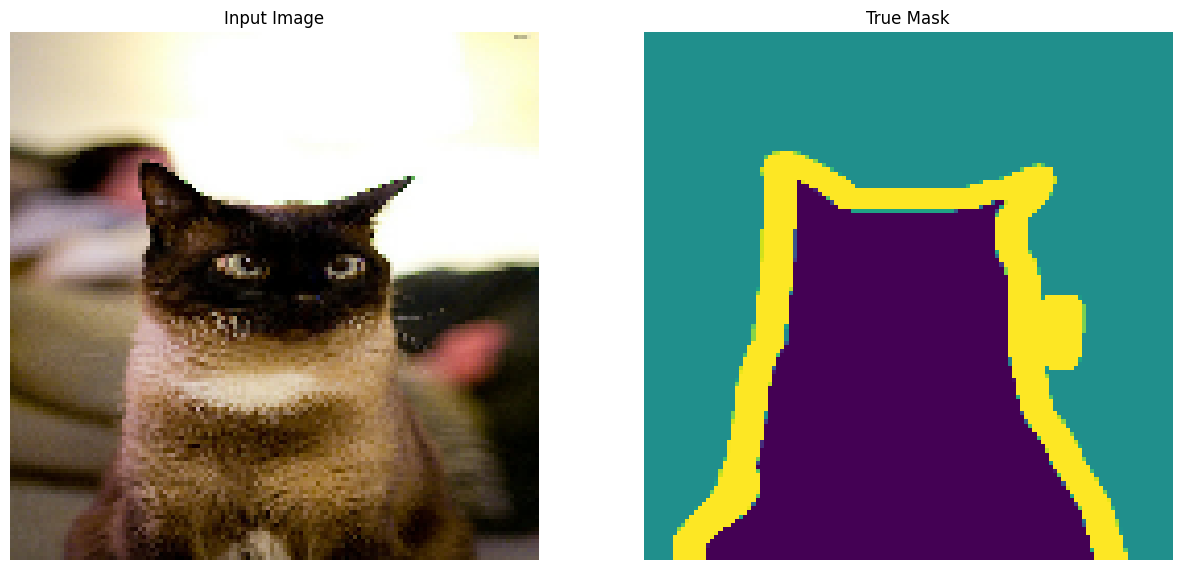

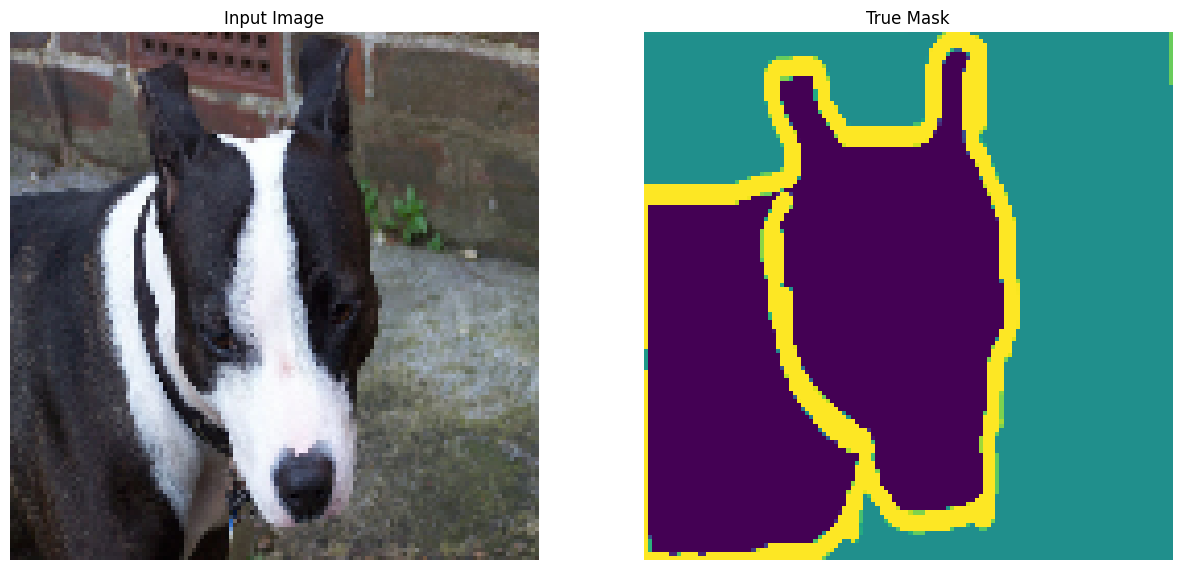

2022-09-19 18:23:40.507918: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## Define the model

The model being used here is a modified [U-Net]. A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, we use a pretrained model -- [MobileNetV2] --as the encoder. For the decoder, we will use the upsample block, which is already implemented in the [pix2pix] example in TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditinoal GAN](https://www.tensorflow.org/tutorials/generative/pix2pix) tutorial in a notebook.)

As mentioned, the encoder is a pretrained MobileNetV2 model. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

[U-Net]: https://arxiv.org/abs/1505.04597
[MobileNetV2]: https://arxiv.org/abs/1801.04381
[pix2pix]: https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py

In [18]:
class Encoder(tf.keras.layers.Layer):
    def __init__(
        self, input_shape: tuple[int, int, int] = IMG_SHAPE,
    ) -> None:
        """Encode the image with a pre-trained model.

        Args:
          input_shape (tuple[int, int, int]): Image input shape.
        """
        super(Encoder, self).__init__()

        model = tf.keras.applications.MobileNetV2(
            input_shape=input_shape, include_top=False,
        )

        # Use the activations of these layers.
        layer_names = [
          'block_1_expand_relu',   # 64x64
          'block_3_expand_relu',   # 32x32
          'block_6_expand_relu',   # 16x16
          'block_13_expand_relu',  # 8x8
          'block_16_project',      # 4x4
        ]

        model_output = [model.get_layer(name).output
                        for name in layer_names]
        self.encoder_model = tf.keras.Model(inputs=model.input,
                                            outputs=model_output)
        self.encoder_model.trainable = False
  
    def call(
        self, x: tf.TensorArray, training: bool = False,
    ) -> list[tf.TensorArray]:
        """Encode the image with an input.

        Args:
          x (tf.TensorArray): Image to encode with shape
            [batch_size, img_height, img_widht, img_channel].
          training (bool, optional): Training mode. Defaults to False.

        Returns:
          tf.TensorArray - List of encoded output from each layer of interest.
        """
        return self.encoder_model(x)


class UNet(tf.keras.Model):
    def __init__(
        self, input_shape: tuple[int, int, int] = IMG_SHAPE,
        output_channels: int = OUTPUT_CLASSES,
        dropout: float = 0.5,
    ) -> None:
        """U-Net: Convolutional Networks for Biomedical Image Segmentation.

        Source: <https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/>

        Args:
          input_shape (tuple[int, int, int]): Input shape. Defaults to IMG_SHAPE.
          output_channels (int): Number of output channels.
            Defaults to OUTPUT_CLASSES.
          dropout (float): Dropout rate. Defaults to 0.5.
        """
        super(UNet, self).__init__()
        self.encoder = Encoder(input_shape=input_shape)

        # Don't train the encoer.
        self.encoder.trainable = False

        decoder_filters = [512, 256, 128, 64]
        initializer = tf.random_normal_initializer(0., 0.02)
        self.concat = tf.keras.layers.Concatenate()

        # Decoder (upsampler).
        self.decoder_stack = [tf.keras.Sequential([
          tf.keras.layers.Conv2DTranspose(
            filters, kernel_size=3, strides=2,
            padding='same', use_bias=False,
            kernel_initializer=initializer,
          ),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(dropout),
          tf.keras.layers.ReLU(),
        ]) for filters in decoder_filters]

        # Final (output) layer.
        self.output_layer = tf.keras.layers.Conv2DTranspose(
            filters=output_channels, kernel_size=3,
            strides=2, padding='same',
        )

    def call(
        self, inputs: tf.TensorArray, training: bool = False,
    ) -> tf.TensorArray:
        """Call the U-Net model with input(s).

        Args:
          input (tf.TensorArray): Input image with shape
            [batch_size, img_height, img_width, img_channel].
          training (bool, optional): Training mode. Defaults to False.

        Returns:
          tf.TensorArray - Predicted output image mask.
        """
        # Downsampling.
        encoder_outputs = self.encoder(inputs)
        x = encoder_outputs[-1]

        # Skip connections.
        skips = reversed(encoder_outputs[:-1])

        # Upsampling and establishing the skip connections.
        for decoder, skip in zip(self.decoder_stack, skips):
            x = decoder(x)
            x = self.concat([x, skip])

        # This is the last layer of the model
        output = self.output_layer(x)
        return output

### Create & compile model

In [19]:
model = UNet(input_shape=IMG_SHAPE,
             output_channels=OUTPUT_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Save & load model weights

In [20]:
# Build the model with input shape.
model.build(input_shape=[None, *IMG_SHAPE])

# Save the model's weights
model.save_weights(MODEL_CKPT.format(epoch=0))

# Load model weights from checkpoint.
# model.load_weights(MODEL_CKPT)

### Visualize model

In [21]:
# tf.keras.utils.plot_model(
#     model,
#     to_file=os.path.join(VIZ_DIR, 'unet.png'),
#     show_shapes=True,
# )
model.summary()

Model: "u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1841984   
                                                                 
 concatenate (Concatenate)   multiple                  0         
                                                                 
 sequential (Sequential)     (None, 8, 8, 512)         1476608   
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 256)       2507776   
                                                                 
 sequential_2 (Sequential)   (None, 32, 32, 128)       516608    
                                                                 
 sequential_3 (Sequential)   (None, 64, 64, 64)        156928    
                                                                 
 conv2d_transpose_4 (Conv2DT  multiple                 4323  

In [22]:
def create_mask(pred_mask: tf.TensorArray) -> tf.TensorArray:
    """Create image mask with predicted output.

    Args:
        pred_mask (tf.TensorArray): Predicted image mask with shape
            [batch_size, img_height, img_width, img_channel].

    Returns:
        tf.TensorArray - Prediction mask with shape
            [img_height, img_width, img_channel]
    """
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]


def show_predictions(
    model: tf.keras.Model | None = None,
    dataset: tf.data.Dataset | None = None,
    num: int = 1
) -> None:
    """Display image, image mask and predicted mask.

    Args:
    model (tf.keras.Model, optional): Model to use for prediction.
        Defaults to None.
    dataset (tf.data.Dataset, optional): Dataset containing
        image & image mask.
        Each with shape [batch_size, img_height, img_width, img_channel].
        Defaults to None.
    num (int): Number of images triples to display. Defaults to 1.
    """
    if dataset:
        for image, mask in dataset.take(num):
            if model is not None:
                pred_mask = model.predict(image)
                display([image[0], mask[0], create_mask(pred_mask)])
            else:
                display([image[0], mask[0]])
    else:
        if model is not None:
            pred_mask = model.predict(sample_image[tf.newaxis, ...])
            display([sample_image, sample_mask, create_mask(pred_mask)])
        else:
            display([sample_image, sample_mask])

In [23]:
train_images.take(2)

<TakeDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>

2022-09-19 18:23:41.975311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 541ms/step


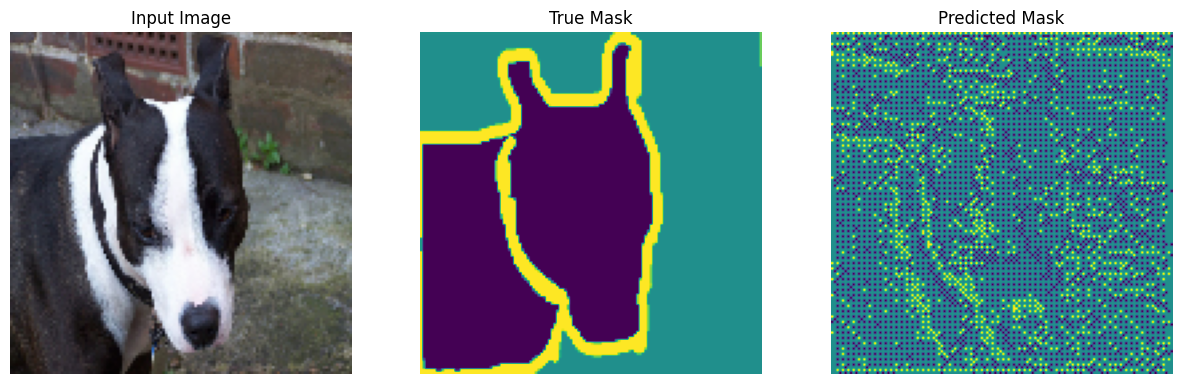

In [24]:
show_predictions(model=model)

### Train model

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch: int, logs: dict | None = None) -> None:
        clear_output(wait=True)
        show_predictions(model=model)
        print(f'\nSample prediction after {epoch+1} epoch(s)\n')

In [26]:
callbacks = [
    # Display predictions at every epoch.
    DisplayCallback(),
    
    # Save model's checkpoint.
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_CKPT,
        save_weights_only=True,
        save_freq=SAVE_FREQ,
        verbose=1,
    ),
    
    # Tensorboard log.
    tf.keras.callbacks.TensorBoard(
        log_dir=MODEL_LOG_DIR,
    ),
    
    # Early stopping.
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
]

1/1 [==============================] - 0s 35ms/step


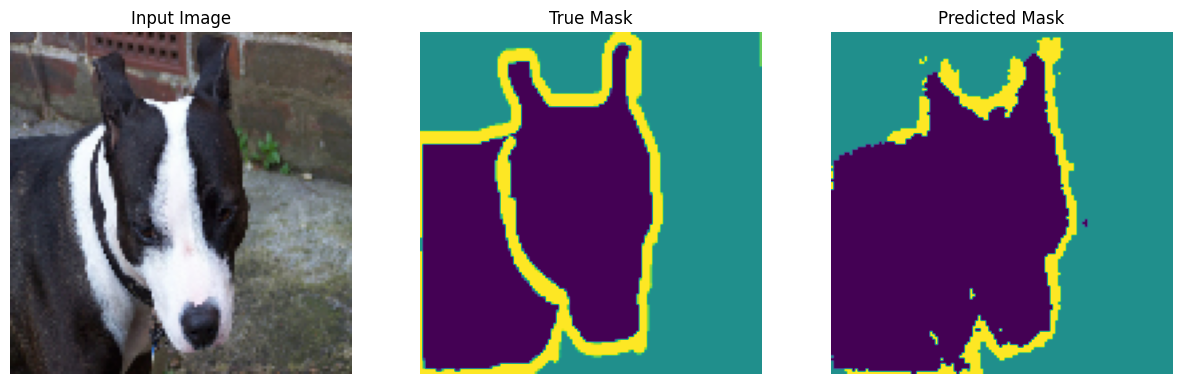


Sample prediction after 10 epoch(s)

57/57 [==============================] - 33s 587ms/step - loss: 0.2651 - accuracy: 0.8900 - val_loss: 0.2735 - val_accuracy: 0.8904


In [27]:
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    validation_data=test_batches,
    callbacks=callbacks,
)

### Visualize training history

In [28]:
def visualize_training(history: tf.keras.callbacks.Callback) -> None:
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure()
    plt.title('Training & Validation Loss')

    plt.plot(history.epoch, loss, 'r', label='Training loss')
    plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])

    plt.legend()
    plt.show()

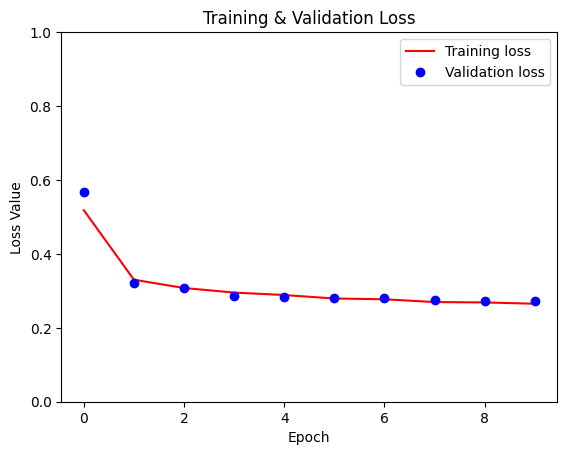

In [29]:
visualize_training(history)

## Make predictions

2/2 [==============================] - 0s 106ms/step


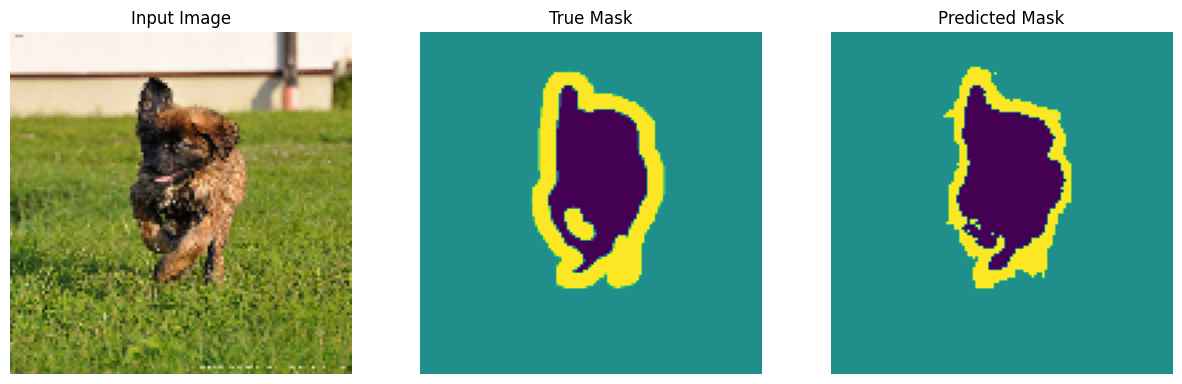

2/2 [==============================] - 0s 135ms/step


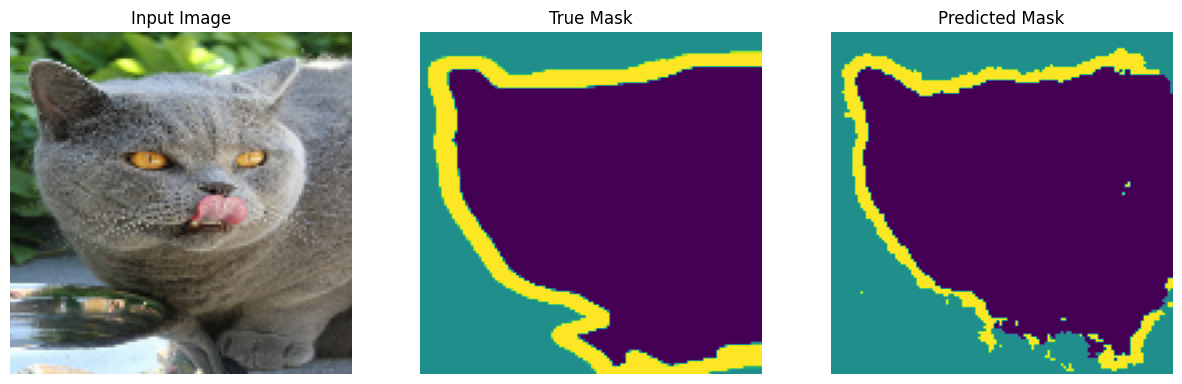

2/2 [==============================] - 0s 140ms/step


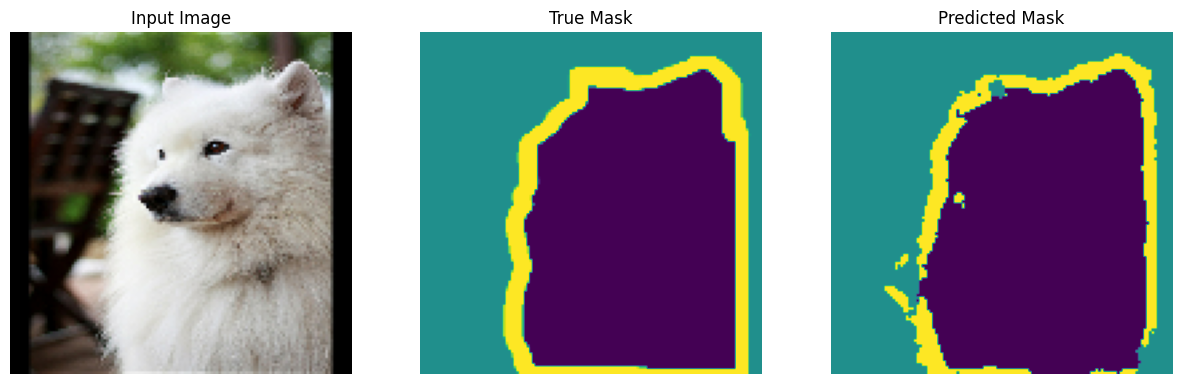

In [30]:
show_predictions(model=model, dataset=test_batches, num=3)

## Save model

In [31]:
# Save model (as .pb)
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: ../../../saved_models/unet/weights/assets


INFO:tensorflow:Assets written to: ../../../saved_models/unet/weights/assets


In [32]:
# Convert to TFLite for on-device inference.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(TF_LITE_MODEL, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpib94xrq0/assets


INFO:tensorflow:Assets written to: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpib94xrq0/assets
2022-09-19 18:32:21.098531: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-09-19 18:32:21.098559: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-09-19 18:32:21.099474: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpib94xrq0
2022-09-19 18:32:21.124928: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-09-19 18:32:21.124948: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmpib94xrq0
2022-09-19 18:32:21.202799: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-09-19 18:32:21.220539: I tensorflow/cc/saved_model/load

## Optional: Imbalanced classes & class weight

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since sementation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weigghing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to [Classification onimbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) to learn more.

To [avoid ambiguity], [`Model.fit`] does not support `class_weight` argument for inputs with 3+ dimensions.

[avoid ambiguity]: https://github.com/keras-team/keras/issues/3653#issuecomment-243939748
[`Model.fit`]: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [33]:
try:
    history = model.fit(
        train_batches, epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        class_weight={0: 2.0, 1: 2.0, 2: 1.0},
    )
    assert False
except Exception as e:
    print(f'Expected {type(e).__name__}: {e}')

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


So, in this case you need to implement the weighting yourself. You'll do this using sample weights; In addition to `(data, label)` pairs, [`Model.fit`] also accepts `(data, label, sample_weight)` triples.

Keras [`Model.fit`] propagates the `sample_weight` to the losses and metrics, which also accepts a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:

[`Model.fit`]: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [34]:
label = [0, 0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction=tf.keras.losses.Reduction.NONE
)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

### Add sample weights

So, to make samle weights, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple. Where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a `class_weight` list:

In [35]:
def add_sample_weights(
    image: tf.TensorArray, label: tf.TensorArray
) -> tuple[tf.TensorArray, tf.TensorArray, tf.TensorArray]:
    """Add sample weight.
    
    Arguments:
        image (tf.TensorArray): Images.
        label (tf.TensorArray): Labels.
    
    Returns:
        tuple[tf.TensorArray, tf.TensorArray, tf.TensorArray]:
            Corresponding to (image, label, sample_weight)
    """
    # The weight for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([2.0, 2.0, 1.0])
    class_weights /= tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label
    # at each pixel as an index into the `class_weights`.
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [36]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

### Create a weighted model

In [37]:
weighted_model = UNet(input_shape=IMG_SHAPE,
                      output_channels=OUTPUT_CLASSES)
weighted_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Save & load weighted model's weights

In [38]:
# Build the model with input shape.
weighted_model.build(input_shape=[None, *IMG_SHAPE])

# Save the model's weights
weighted_model.save_weights(WEIGHTED_MODEL_CKPT.format(epoch=0))

# Load model weights from checkpoint.
# weighted_model.load_weights(WEIGHTED_MODEL_CKPT)

### Visualize the weighted model

In [39]:
# tf.keras.utils.plot_model(
#     weighted_model,
#     to_file=os.path.join(VIZ_DIR, 'unet-weighted.png'),
#     show_shapes=True,
# )
weighted_model.summary()

Model: "u_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1841984   
                                                                 
 concatenate_1 (Concatenate)  multiple                 0         
                                                                 
 sequential_4 (Sequential)   (None, 8, 8, 512)         1476608   
                                                                 
 sequential_5 (Sequential)   (None, 16, 16, 256)       2507776   
                                                                 
 sequential_6 (Sequential)   (None, 32, 32, 128)       516608    
                                                                 
 sequential_7 (Sequential)   (None, 64, 64, 64)        156928    
                                                                 
 conv2d_transpose_9 (Conv2DT  multiple                 4323

### Train a weighted model

In [40]:
class DisplayWeightedCallback(tf.keras.callbacks.Callback):
    """Display predictions on sample image at the end of each epoch."""

    def on_epoch_end(self, epoch: int, logs: dict | None = None) -> None:
        """Display prediction triples after each epoch.

        Args:
          epoch (int): Current epoch.
          logs (dict, optional): Other log info.
        """
        clear_output(wait=True)
        show_predictions(model=weighted_model)
        print(f'\nSample prediction after {epoch + 1} epoch(s)\n')

In [41]:
callbacks = [
    # Display predictions at every epoch.
    DisplayWeightedCallback(),

    # Save model checkpoint.
    tf.keras.callbacks.ModelCheckpoint(
        filepath=WEIGHTED_MODEL_CKPT,
        save_weights_only=True,
        save_freq=SAVE_FREQ,
        verbose=1,
    ),
     
    # Tensorboard log.
    tf.keras.callbacks.TensorBoard(
        log_dir=WEIGHTED_MODEL_LOG_DIR,
    ),

    # Early stopping.
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
]

1/1 [==============================] - 0s 35ms/step


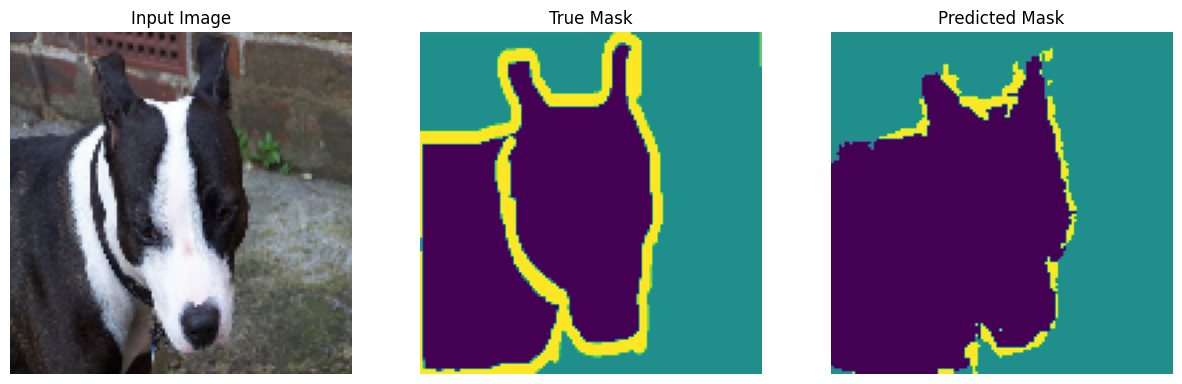


Sample prediction after 10 epoch(s)

57/57 [==============================] - 33s 587ms/step - loss: 0.0819 - accuracy: 0.8804 - val_loss: 0.0847 - val_accuracy: 0.8788


In [42]:
# Train weighted model.
weighted_history = weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    validation_data=test_batches.map(add_sample_weights),
    callbacks=callbacks,
)

### Visualize training history

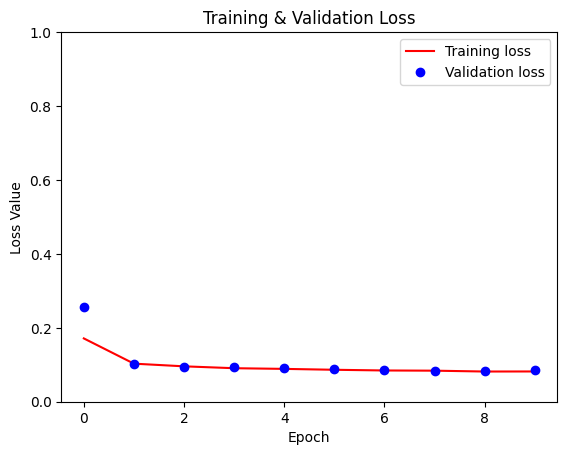

In [43]:
visualize_training(history=weighted_history)

### Make predictions

2/2 [==============================] - 0s 95ms/step


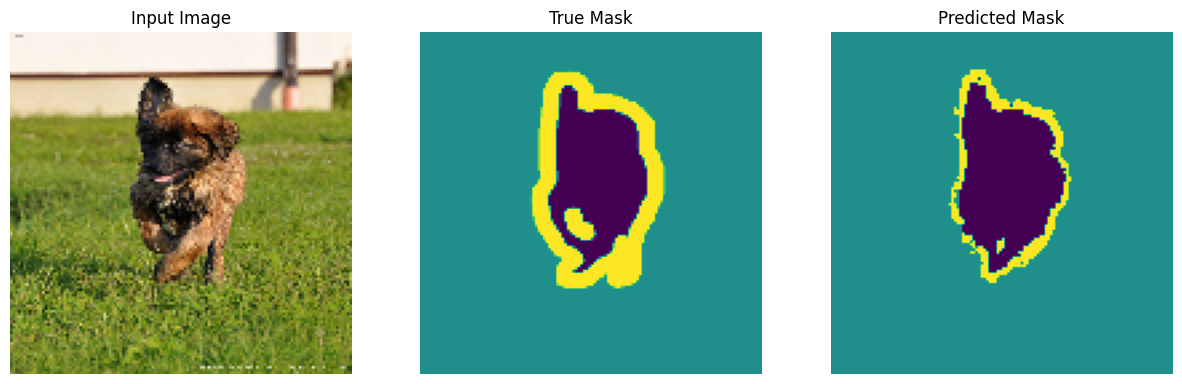

2/2 [==============================] - 0s 138ms/step


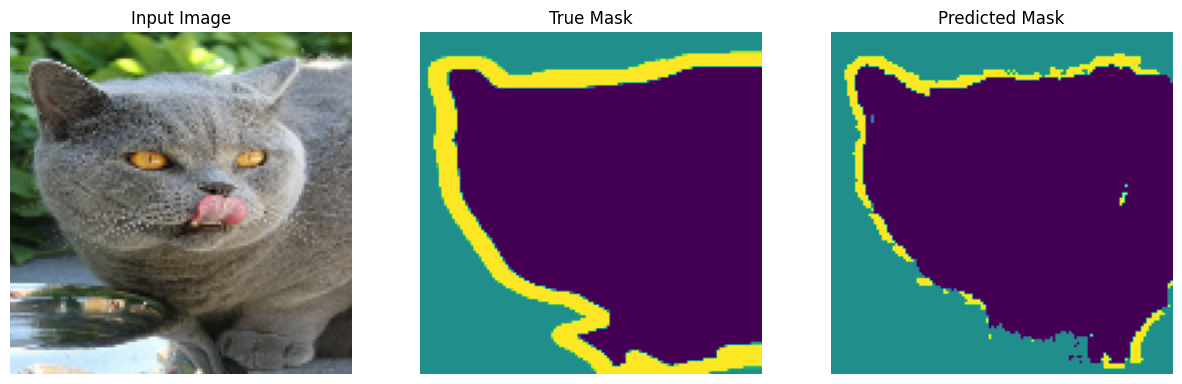

2/2 [==============================] - 0s 135ms/step


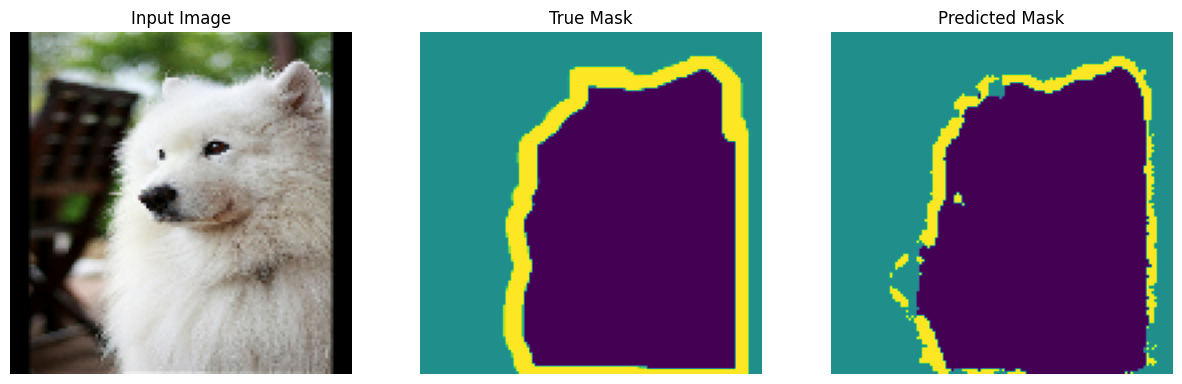

In [44]:
show_predictions(model=weighted_model, dataset=test_batches, num=3)

## Save weighted model

In [45]:
# Save model (as .pb)
weighted_model.save(WEIGHTED_MODEL_PATH)

INFO:tensorflow:Assets written to: ../../../saved_models/unet-weighted/weights/assets


INFO:tensorflow:Assets written to: ../../../saved_models/unet-weighted/weights/assets


In [46]:
# Convert the TFLite for on-device inference
weighted_converter = tf.lite.TFLiteConverter.from_keras_model(weighted_model)
tflite_weighted_model = weighted_converter.convert()

with open(TF_LITE_WEIGHTED_MODEL, 'wb') as f:
    f.write(tflite_weighted_model)

INFO:tensorflow:Assets written to: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmp026g5k95/assets


INFO:tensorflow:Assets written to: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmp026g5k95/assets
2022-09-19 18:39:36.368743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-09-19 18:39:36.368763: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-09-19 18:39:36.368882: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmp026g5k95
2022-09-19 18:39:36.394472: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-09-19 18:39:36.394492: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/99/y3r4vtrx335gvk8f_0vp7ffw0000gn/T/tmp026g5k95
2022-09-19 18:39:36.490595: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-09-19 18:39:36.835563: I tensorflow/cc/saved_model/loader.cc:212] Running initialization